<a href="https://colab.research.google.com/github/ericburdett/author-id-network/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Author Identification**
#### Eric Burdett

This notebook contains code that can successfully identify authors given a page of handwritten text. The datasets used come from the Missionary Journals dataset that is made available from the BYU library. This work is based off of the following papers:

*   Paper #1
*   Paper #2


##Install PyTorch and Import Dependencies

##Import & Create Missionary Journal Dataset

In [0]:
# Copy the dataset over to colab
!cp "drive/My Drive/datasets/missionary.tar.gz" "/content"

In [0]:
# Extract into /content/missionary
!tar xzf missionary.tar.gz

In [0]:
class MissionaryDataset(Dataset):
  def __init__(self, size=256):
    if not os.path.exists('/content/missionary'):
      raise Exception('Missionary dataset does not exist in /content/missionary')

    # # Only resize and set dataset_folder once
    # if not os.path.exists(os.path.join('/content/missionary/Ajax_William/0.bmp')):
    #   self.resize('/content/missionary', size)
    
    self.dataset_folder = torchvision.datasets.ImageFolder('/content/missionary',
        transform=transforms.Compose([transforms.ToTensor()]))

  def num_classes(self):
    return len(self.dataset_folder.class_to_idx)

  def resize(self, path, size):
    """Resizes all images in place"""
    print("Resizing images")
    dirs = os.walk(path)
    for root, dirs, files in os.walk(path):
        for item in files:
            name = os.path.join(root, item)
            if os.path.isfile(name):
                im = Image.open(name)
                im = ImageOps.fit(im, (size, size))
                im.save(name[:-3] + 'bmp', 'BMP')
                os.remove(name)

  def idx_to_class(self, idx):
    for key, value in self.dataset_folder.class_to_idx.items():
      if value == idx:
        return key
    
    raise Exception('Class not found for index ' + idx)

  def __getitem__(self, index):
    return self.dataset_folder[index]

  def __len__(self):
    return len(self.dataset_folder)

In [40]:
dataset = MissionaryDataset()
dataset.__getitem__(0)[1]

0

## Author Samples

In [0]:
dataset = MissionaryDataset()
index = 0
for img, label in dataset:
  if label == index:
    plt.title(dataset.idx_to_class(label))
    plt.imshow(img.permute(1,2,0))
    index += 1

In [0]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
from PIL import Image, ImageOps
import gc
import pdb
from google.colab import drive
drive.mount('/content/drive')
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "Request a GPU from Runtime > Change Runtime"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##Create our model using a CNN

In [0]:
class AuthorIdNetwork(nn.Module):
  def __init__(self, dataset):
    super(AuthorIdNetwork, self).__init__()

    x, y = dataset[0]
    in_channels, height, width = x.size()

    num_classes = dataset.num_classes()

    CONV1_CHANNELS = 96
    CONV1_SIZE = (5, 5)
    CONV1_STRIDE = 1
    CONV1_PADDING = 2
    CONV2_5_CHANNELS = 256 
    CONV2_5_SIZE = (3, 3)
    CONV2_5_STRIDE = 1
    CONV2_5_PADDING = 1
    CONV3_4_CHANNELS = 384
    CONV3_4_SIZE = (3, 3)
    CONV3_4_STRIDE = 1
    CONV3_4_PADDING = 1
    FC_COUNT = 1024
    self.fc_input = CONV2_5_CHANNELS * (height // 8) * (width // 8)

    MP_SIZE= (3, 3)
    MP_STRIDE = 2
    MP_PADDING = 1

    self.conv1 = nn.Conv2d(in_channels, CONV1_CHANNELS, CONV1_SIZE, stride=CONV1_STRIDE, padding=CONV1_PADDING)
    self.relu1 = nn.ReLU()
    self.mp1 = nn.MaxPool2d(MP_SIZE, stride=MP_STRIDE, padding=MP_PADDING)
    self.conv2 = nn.Conv2d(CONV1_CHANNELS, CONV2_5_CHANNELS, CONV2_5_SIZE, stride=CONV2_5_STRIDE, padding=CONV2_5_PADDING)
    self.relu2 = nn.ReLU()
    self.mp2 =  nn.MaxPool2d(MP_SIZE, stride=MP_STRIDE, padding=MP_PADDING)
    self.conv3 = nn.Conv2d(CONV2_5_CHANNELS, CONV3_4_CHANNELS, CONV3_4_SIZE, stride=CONV3_4_STRIDE, padding=CONV3_4_PADDING)
    self.relu3 = nn.ReLU()
    self.conv4 = nn.Conv2d(CONV3_4_CHANNELS, CONV3_4_CHANNELS, CONV3_4_SIZE, stride=CONV3_4_STRIDE, padding=CONV3_4_PADDING)
    self.relu4 = nn.ReLU()
    self.conv5 = nn.Conv2d(CONV3_4_CHANNELS, CONV2_5_CHANNELS, CONV2_5_SIZE, stride=CONV2_5_STRIDE, padding=CONV2_5_PADDING)
    self.relu5 = nn.ReLU()
    self.mp3 = nn.MaxPool2d(MP_SIZE, stride=MP_STRIDE, padding=MP_PADDING)
    self.fc1 = nn.Linear(self.fc_input, FC_COUNT, bias=True)
    self.relu6 = nn.ReLU()
    self.fc2 = nn.Linear(FC_COUNT, num_classes, bias=True)
    self.relu7 = nn.ReLU()
    # self.drop = nn.Dropout(p=0.5)
    self.soft = nn.Softmax(dim=0)

  def forward(self, x):
    batch_size = x.shape[0]

    conv1_out = self.conv1(x)
    # print('conv1_out:', conv1_out.shape)
    relu1_out = self.relu1(conv1_out)
    mp1_out = self.mp1(relu1_out)
    # print('mp1_out:', mp1_out.shape)
    conv2_out = self.conv2(mp1_out)
    # print('conv2_out:', conv2_out.shape)
    relu2_out = self.relu2(conv2_out)
    mp2_out = self.mp2(relu2_out)
    # print('mp2_out:', mp2_out.shape)
    conv3_out = self.conv3(mp2_out)
    # print('conv3_out:', conv3_out.shape)
    relu3_out = self.relu3(conv3_out)
    conv4_out = self.conv4(relu3_out)
    # print('conv4_out:', conv4_out.shape)
    relu4_out = self.relu4(conv4_out)
    conv5_out = self.conv5(relu4_out)
    # print('conv5_out:', conv5_out.shape)
    relu5_out = self.relu5(conv5_out)
    mp3_out = self.mp3(relu5_out)
    # print('mp3_out:', mp3_out.shape)
    mp3_out_viewed = mp3_out.view(batch_size, self.fc_input)
    fc1_out = self.fc1(mp3_out_viewed)
    # print('fc1_out:', fc1_out.shape)
    relu6_out = self.relu6(fc1_out)
    fc2_out = self.fc2(relu6_out)
    # print('fc2_out:', fc2_out.shape)
    relu7_out = self.relu7(fc2_out)
    # drop_out = self.drop(relu7_out)
    # print('drop_out:', drop_out.shape)
    soft_out = self.soft(relu7_out)
    # print('soft_out:', soft_out.shape)

    return soft_out

In [0]:
class ResNetMissionary(nn.Module):
  def __init__(self, num_classes):
    super(ResNetMissionary, self).__init__()

    self.model = torchvision.models.resnet152(pretrained=True)

    fc = nn.Linear(in_features=2048, out_features=num_classes)
    fc.requires_grad=True
    self.model.fc = fc

  def forward(self, x):
    return self.model(x)

##Training

In [0]:
def train():
  NUM_EPOCHS = 10
  BATCH_SIZE = 50

  dataset = MissionaryDataset()
  train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(.8 * len(dataset)), int(.2 * len(dataset))])

  # model = AuthorIdNetwork(dataset)
  model = ResNetMissionary(dataset.num_classes())
  model = model.cuda()

  objective = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  train_loader = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                            num_workers=4,
                            shuffle=True)
  
  val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)
  
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []

  for epoch in range(NUM_EPOCHS):
    loop = tqdm(total=len(train_loader), position=0, leave=False)

    for batch, (x, y_truth) in enumerate(train_loader):
      gc.collect()
      x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)

      optimizer.zero_grad()
      y_hat = model(x)

      accuracy = torch.eq(y_hat.argmax(1), y_truth.long()).float().mean()
      loss = objective(y_hat, y_truth.long())

      loss.backward()

      train_losses.append(loss.item())
      train_accs.append(accuracy.item())

      loop.set_description('epoch:{}, loss:{:.4f}, acc:{:.4f}, avgloss:{:.4f}, avgacc:{:.4f}'
          .format(epoch, loss.item(), accuracy.item(), np.mean(train_losses), np.mean(train_accs)))
      loop.update(1)

      optimizer.step()


    with torch.no_grad():
      gc.collect()

      val_single_acc = []
      val_single_loss = []

      model.eval()
      
      for _, (val_x, val_y_truth) in enumerate(val_loader):
        val_x, val_y_truth = val_x.cuda(), val_y_truth.cuda()

        val_y_hat = model(val_x)

        val_accuracy = torch.eq(val_y_hat.argmax(1), val_y_truth).float().mean().item()
        val_loss = objective(val_y_hat, val_y_truth).float().mean().item()

        val_single_acc.append(val_accuracy)
        val_single_loss.append(val_loss)
      
      print('validation - loss:{:.4f}, accuracy:{:.4f}'.format(np.array(val_single_loss).mean(), np.array(val_single_acc).mean()))

      model.train()

    val_accs.append(np.array(val_single_acc).mean())
    val_losses.append(np.array(val_single_loss).mean())
    
  loop.close()

  return model, train_losses, val_losses, train_accs, val_accs

try:
  model, train_losses, val_losses, train_accs, val_accs = train()
  gc.collect()
except:
  gc.collect()
  __ITB__()

  0%|          | 0/246 [00:00<?, ?it/s]

validation - loss:0.7108, accuracy:1.0989


  0%|          | 0/246 [00:00<?, ?it/s]

validation - loss:0.8928, accuracy:0.3719


epoch:2, loss:0.0819, acc:0.9800, avgloss:0.6597, avgacc:0.8140:  22%|██▏       | 55/246 [00:50<02:49,  1.12it/s]

##Results

SyntaxError: ignored

In [58]:
val_loss2 = [np.array(loss).mean() for loss in val_losses]
val_loss2

[0.9272603839635849,
 0.46653701076584475,
 0.49852348431464166,
 0.2828595397933837,
 0.15579888185546284]

In [63]:
dataset = MissionaryDataset()
int(len(dataset) * .8)

12264

In [71]:
len(train_losses)//5

246

In [82]:
[i for i in range(len(train_losses) // 5, len(train_losses) + 1, len(train_losses) // 5)]

[246, 492, 738, 984, 1230]

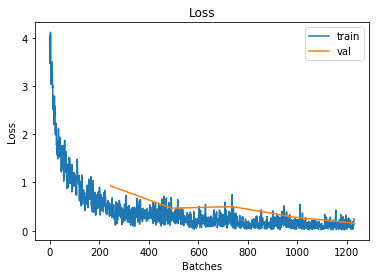

In [105]:
# Plot the Loss
dataset = MissionaryDataset()
length = int(len(dataset) * .8)
y, x = [np.array(loss).mean() for loss in val_losses], range(len(train_losses) // 5, len(train_losses) + 1, len(train_losses) // 5)
plt.title('Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.plot(train_losses, label='train')
plt.plot(x, y, label='val')
plt.legend()
plt.show()

In [106]:
len(x)

5

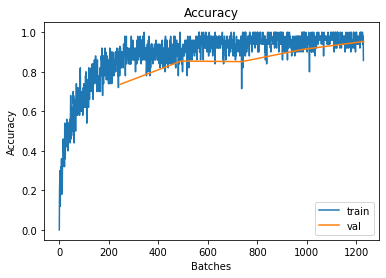

Final Accuracy: 0.9532


In [109]:
# Plot the Accuracy
y, x = [np.array(acc).mean() for acc in val_accs], range(len(train_losses) // 5, len(train_losses) + 1, len(train_losses) // 5)

plt.title('Accuracy')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.plot(train_accs, label='train')
plt.plot(x, y, label='val')
plt.legend()
plt.show()
print('Final Accuracy: {:.4f}'.format(y[-1]))

##Conclusion

The above CNN architecture achieves...

These are the contributions and performance of the model...